In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
# from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS, get_masking_index
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import plot_predictions_on_epoch, plot_eeg
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS
from hmpai.pytorch.mamba import *

In [2]:
set_global_seed(42)
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"]
# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ['event_name', 'participant', 'epochs']
subset_cond = None # 'speed'|'accuracy'|None
skip_samples = 62 #62
cut_samples = 63 #63

In [3]:
norm_fn = norm_mad_zscore
statistics = {
    "global_min": -0.00014557216,
    "global_max": 0.00014740844,
    "global_mean": -2.277374212336032e-18,
    "global_std": 3.3968840765876904e-06,
    "global_median": 3.4879516e-11,
    "mad_score": 3.2237037e-06,
    "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
}
norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    statistics=statistics,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1] + splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)

In [4]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader_sat2 = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [14]:
chk_path = Path("../../models/attlab_jitter.pt")
checkpoint = load_model(chk_path)

model = base_mamba()
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

#### Specific trial

{'event_name': 'low/speed/left/3', 'participant': 'S17', 'epochs': 2087}
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
18831  1.0  speed     left         3  169.0   2087         S17      left   

       response         rt        prmt         mt trialType EMG_sequence  
18831         1  566.40625  490.234375  76.171875        MA          ICR  


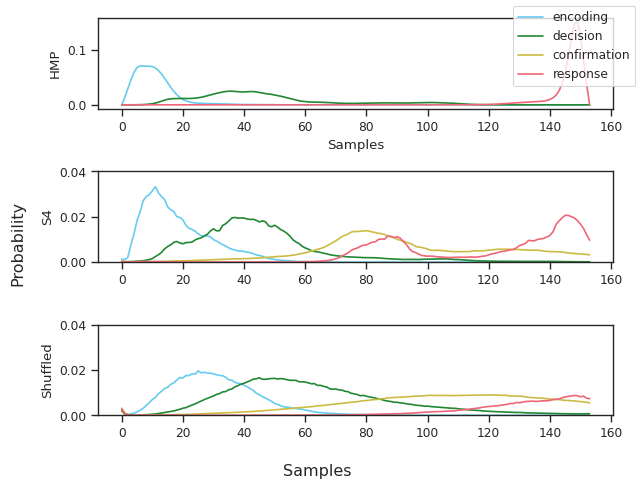

In [ ]:
def display_trial(model, dataset, behaviour, idx: int):
    data = dataset.__getitem__(idx)
    epoch, true, info = data[0], data[1], data[2][0]
    print(info)
    # plot_eeg(epoch)
    p_trial_info = behaviour[(behaviour.trial == info['epochs']) & (behaviour.participant == info['participant'])]
    print(p_trial_info)
    plot_predictions_on_epoch(
        epoch,
        true,
        SAT_CLASSES_ACCURACY,
        window_size=0,
        model=model,
        smoothing=False,
        sequence=True,
        random_perm=True,
        save=True,
    )
# display_trial(4130)
# for i in torch.randint(len(test_data), (10,)):
#     print(i)
#     display_trial(i)
# Speed trial
# display_trial(6260)
# display_trial(4130)
display_trial(4298) # Speed trial with conf

#### Find X

        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
25033  2.0  speed     left         2  187.0   1324          S3     right   

       response         rt        prmt         mt trialType EMG_sequence  
25033         0  308.59375  241.210938  67.382812        SA           IR  


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


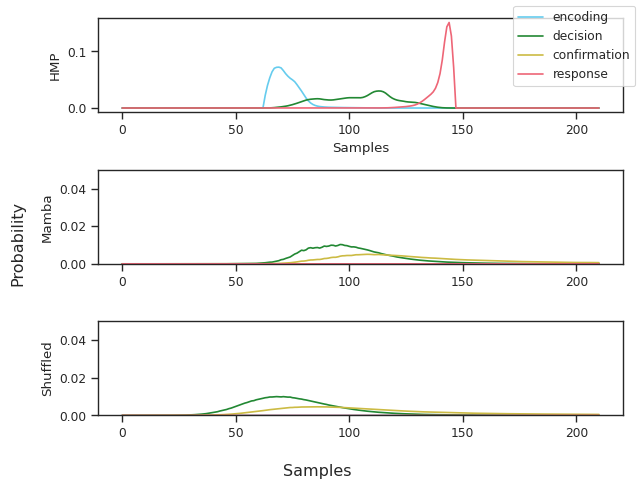

----------
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
41462  2.0  speed    right         3  164.0   2383          S6     right   

       response          rt        prmt        mt trialType EMG_sequence  
41462         1  381.835938  287.109378  94.72656        SA           CR  


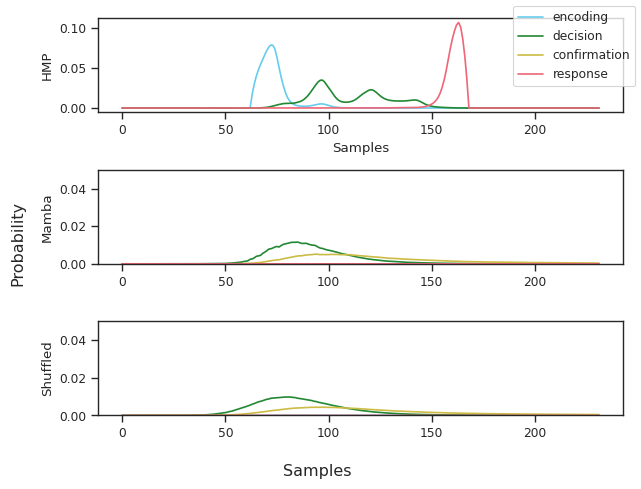

----------
       FC    SAT expdResp  contrast   N200  trial participant givenResp  \
1807  1.0  speed    right         1  152.0   1886         S10     right   

      response          rt     prmt         mt trialType EMG_sequence  
1807         1  286.132812  234.375  51.757812        SA           CR  


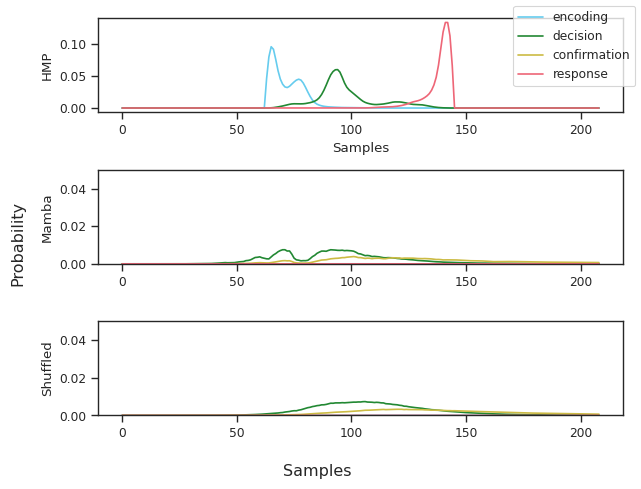

----------
        FC       SAT expdResp  contrast  N200  trial participant givenResp  \
33469  2.0  accuracy     left         3   NaN    352          S1      left   

       response          rt        prmt        mt trialType EMG_sequence  
33469         1  659.179688  572.265627  86.91406        SA           CR  


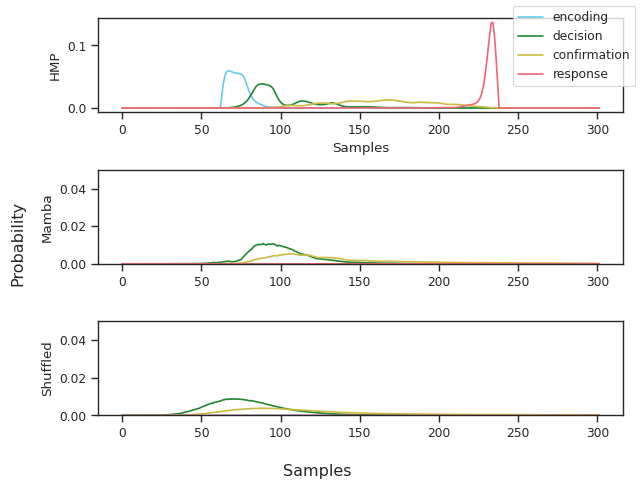

----------
        FC       SAT expdResp  contrast   N200  trial participant givenResp  \
40567  1.0  accuracy     left         1  140.0   1408          S6      left   

       response          rt        prmt         mt trialType EMG_sequence  
40567         1  504.882812  424.804685  80.078128        SA           CR  


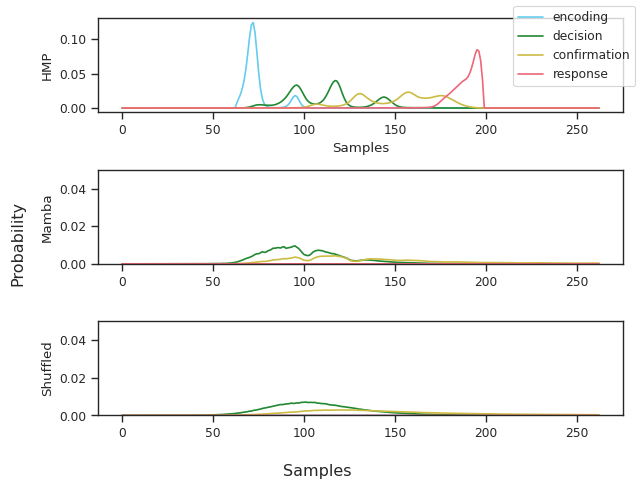

----------


In [8]:
# SAT2
window_size = 0
amount_of_graphs = 5
counter = 0
for batch in test_loader_sat2:
    info = batch[2][0]
    for epoch, true, participant, trial in zip(batch[0], batch[1], info['participant'], info['epochs']):
        # Change function to support whole sequence
        p_trial_info = behaviour_sat2[(behaviour_sat2.trial == trial.item()) & (behaviour_sat2.participant == participant)]
        print(p_trial_info)
        plot_predictions_on_epoch(
            epoch,
            true,
            SAT_CLASSES_ACCURACY,
            window_size,
            model,
            smoothing=False,
            sequence=True,
            random_perm=True,
        )
        print("----------")
        counter += 1
        if counter >= amount_of_graphs:
            break
    break

        FC       SAT expdResp  contrast   N200  trial participant givenResp  \
14691  2.0  accuracy    right         1  177.0    309          S9     right   

       response          rt       prmt          mt trialType EMG_sequence  
14691         1  657.226562  514.64844  142.578123        SA           CR  


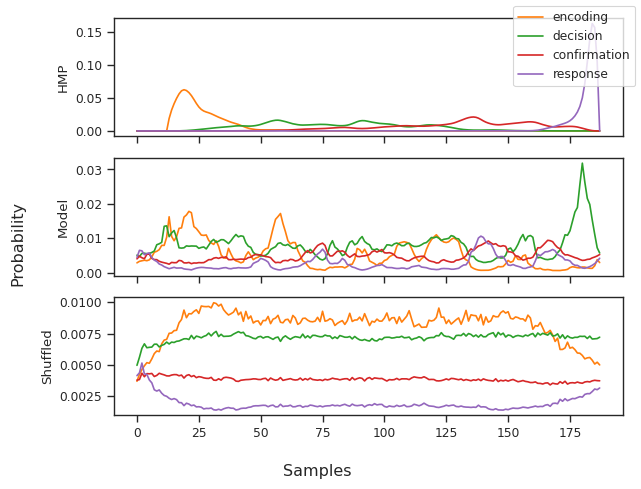

----------
        FC    SAT expdResp  contrast  N200  trial participant givenResp  \
10567  1.0  speed     left         1   NaN   1032         S12      left   

       response          rt        prmt          mt trialType EMG_sequence  
10567         1  467.773438  325.195312  142.578125        SA           CR  


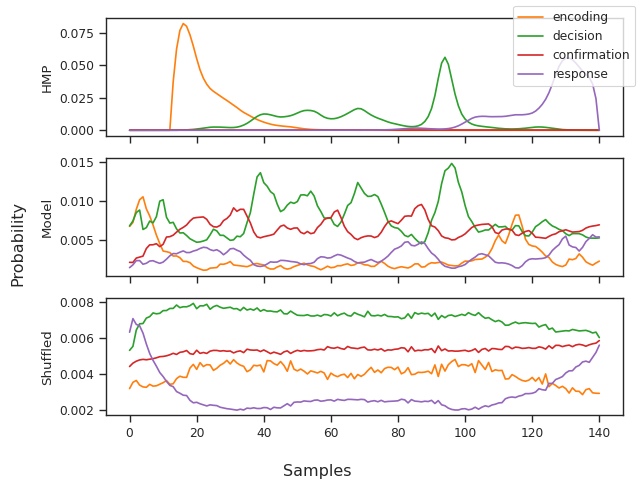

----------
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
34358  1.0  speed    right         1  207.0   1292          S1     right   

       response          rt        prmt        mt trialType EMG_sequence  
34358         1  366.210938  264.648438  101.5625        SA           CR  


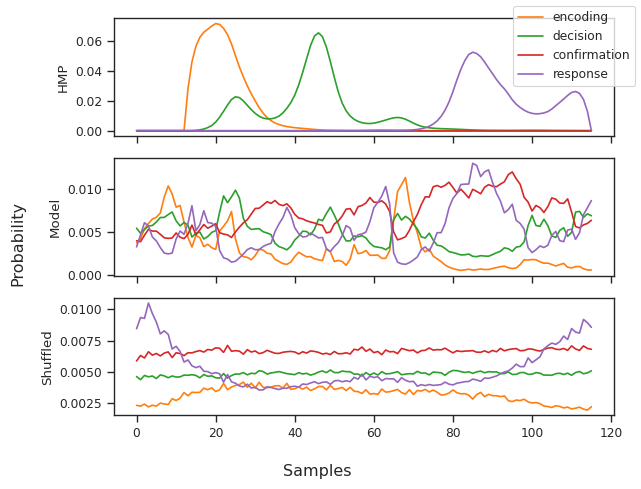

----------
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
11407  2.0  speed    right         1  172.0   1890         S12     right   

       response          rt        prmt          mt trialType EMG_sequence  
11407         1  670.898438  541.992193  128.906245        SA           CR  


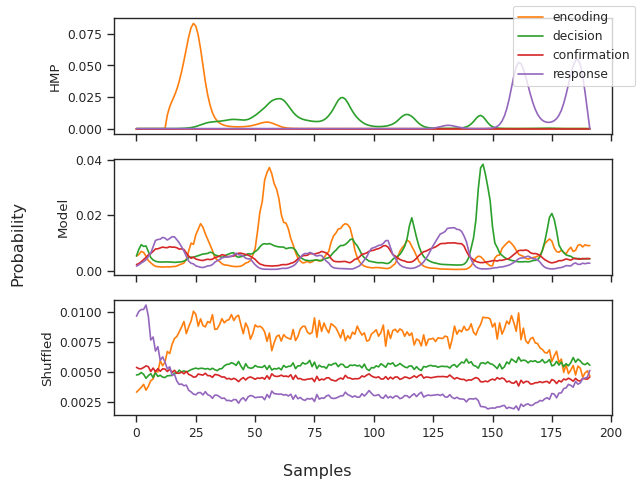

----------
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
33238  1.0  speed    right         2  161.0    117          S1     right   

       response          rt        prmt        mt trialType EMG_sequence  
33238         1  338.867188  242.187497  96.67969        SA           CR  


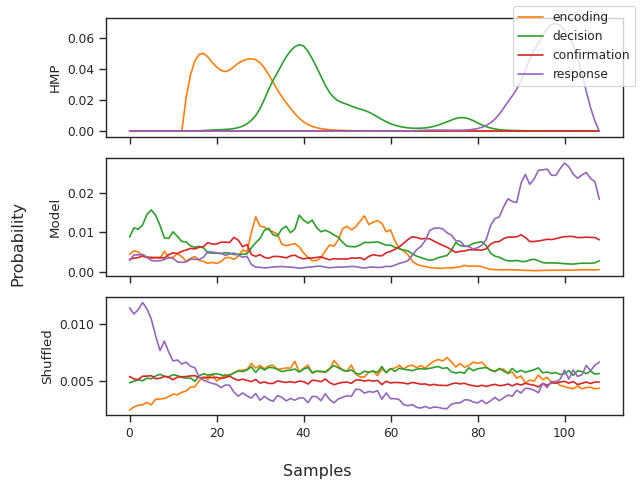

----------


In [15]:
# SAT2
window_size = 50
amount_of_graphs = 5
counter = 0
for batch in test_loader_sat2:
    info = batch[2][0]
    for epoch, true, participant, trial in zip(batch[0], batch[1], info['participant'], info['epochs']):
        # Change function to support whole sequence
        p_trial_info = behaviour_sat2[(behaviour_sat2.trial == trial.item()) & (behaviour_sat2.participant == participant)]
        print(p_trial_info)
        plot_predictions_on_epoch(
            epoch,
            true,
            SAT_CLASSES_ACCURACY,
            window_size,
            model,
            smoothing=False,
            sequence=False,
            random_perm=True,
        )
        print("----------")
        counter += 1
        if counter >= amount_of_graphs:
            break
    break

        FC       SAT expdResp  contrast  N200  trial participant givenResp  \
11310  1.0  accuracy     left         3   NaN   1790         S12      left   

       response          rt  prmt  mt trialType EMG_sequence  
11310         1  876.953125   NaN NaN        UT            R  


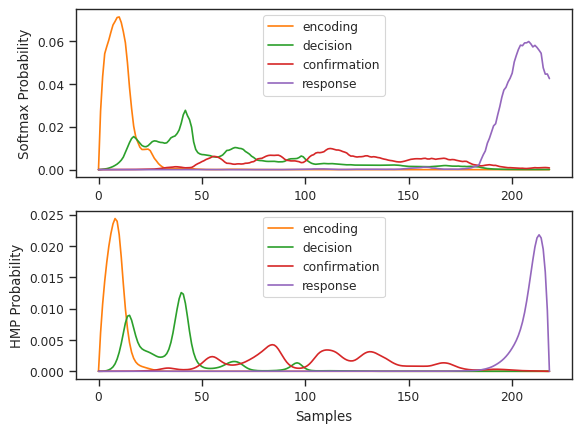

----------
        FC    SAT expdResp  contrast  N200  trial participant givenResp  \
10752  1.0  speed    right         1   NaN   1220         S12     right   

       response          rt  prmt  mt trialType EMG_sequence  
10752         1  529.296875   NaN NaN        UT            R  


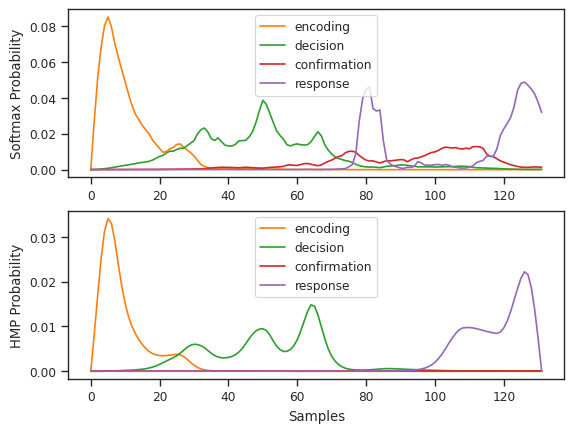

----------
        FC       SAT expdResp  contrast   N200  trial participant givenResp  \
34940  1.0  accuracy    right         3  152.0   1889          S1     right   

       response           rt         prmt        mt trialType EMG_sequence  
34940         1  1198.242188  1132.812497  65.42969        MA          CCR  


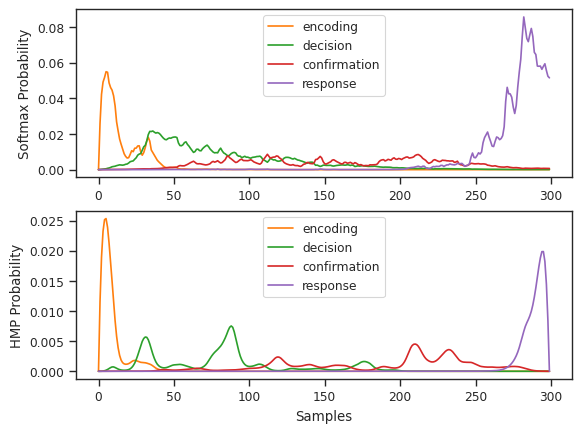

----------
        FC       SAT expdResp  contrast   N200  trial participant givenResp  \
33413  1.0  accuracy    right         3  160.0    294          S1     right   

       response           rt  prmt  mt trialType EMG_sequence  
33413         1  1298.828125   NaN NaN        UT            R  


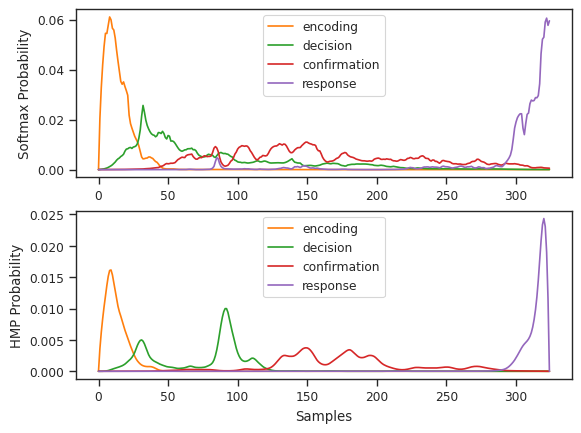

----------
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
35204  2.0  speed     left         1  191.0   2160          S1      left   

       response        rt        prmt         mt trialType EMG_sequence  
35204         1  398.4375  324.218747  74.218753        MA         CICR  


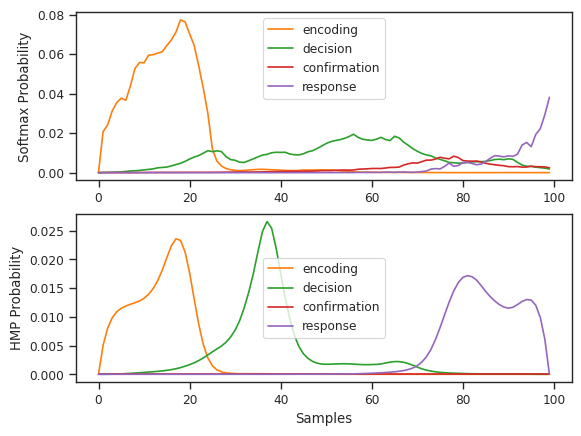

----------
        FC       SAT expdResp  contrast   N200  trial participant givenResp  \
34263  2.0  accuracy    right         1  211.0   1191          S1     right   

       response          rt        prmt        mt trialType EMG_sequence  
34263         1  436.523438  359.374997  77.14844        MA          ICR  


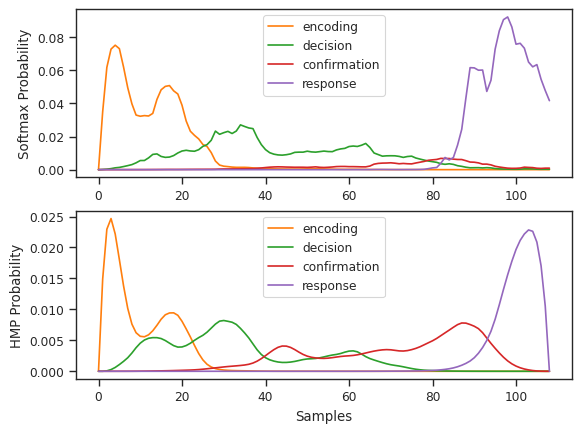

----------
        FC       SAT expdResp  contrast   N200  trial participant givenResp  \
35296  2.0  accuracy    right         2  149.0   2252          S1     right   

       response         rt        prmt         mt trialType EMG_sequence  
35296         1  371.09375  273.437495  97.656255        MA         CCCR  


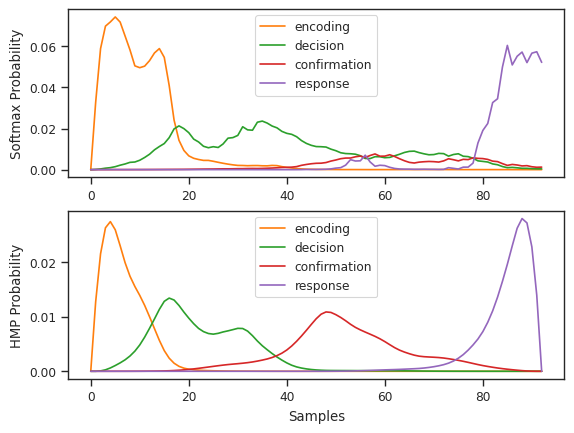

----------
        FC    SAT expdResp  contrast  N200  trial participant givenResp  \
11133  1.0  speed    right         2   NaN   1610         S12     right   

       response          rt  prmt  mt trialType EMG_sequence  
11133         1  444.335938   NaN NaN        UT            R  


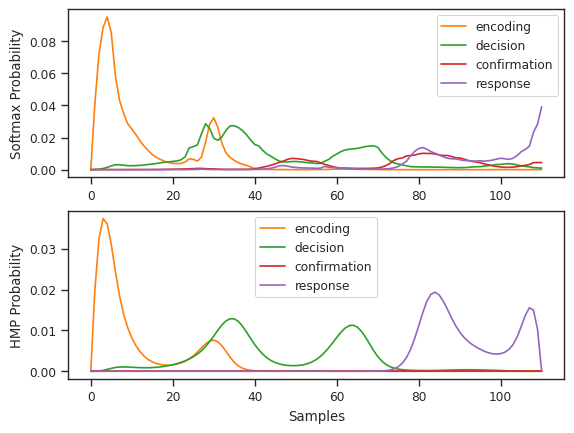

----------
        FC       SAT expdResp  contrast  N200  trial participant givenResp  \
34578  2.0  accuracy    right         1   NaN   1519          S1     right   

       response          rt        prmt          mt trialType EMG_sequence  
34578         1  685.546875  541.992188  143.554688        MA          CCR  


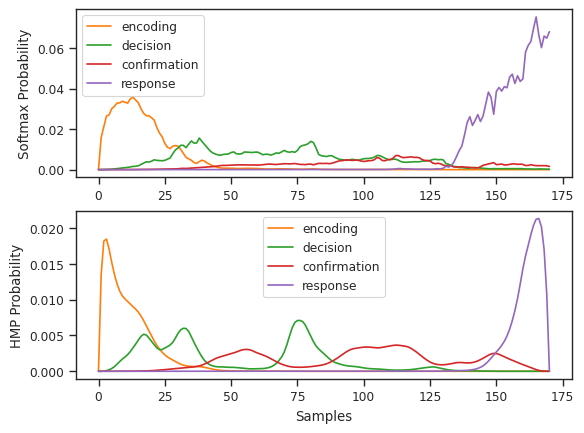

----------
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
11153  1.0  speed     left         1  127.0   1630         S12      left   

       response          rt  prmt  mt trialType EMG_sequence  
11153         1  607.421875   NaN NaN        UT            R  


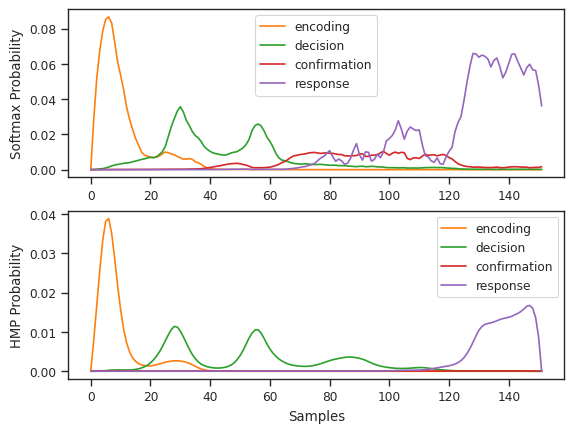

----------


In [42]:
# SAT2
window_size = 10
amount_of_graphs = 10
counter = 0
for batch in test_loader_sat2:
    info = batch[2][0]
    for epoch, true, participant, trial in zip(batch[0], batch[1], info['participant'], info['epochs']):
        # Change function to support whole sequence
        p_trial_info = behaviour_sat2[(behaviour_sat2.trial == trial.item()) & (behaviour_sat2.participant == participant)]
        emg_seq = p_trial_info['EMG_sequence'].item()
        if emg_seq != 'CR' and emg_seq != 'IR':
            print(p_trial_info)
            plot_predictions_on_epoch(
                epoch,
                true,
                SAT_CLASSES_ACCURACY,
                window_size,
                model,
                smoothing=False,
                sequence=True,
                random_perm=False,
            )
            # plot_predictions_on_epoch(
            #     epoch,
            #     true,
            #     SAT_CLASSES_ACCURACY,
            #     window_size,
            #     model,
            #     smoothing=False,
            #     sequence=True,
            #     random_perm=True,
            # )
            print("----------")
            counter += 1
        if counter >= amount_of_graphs:
            break
    break